### Initialization & Loading:

In [442]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, desc, explode, year, avg, count, isnull  
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set_theme(style="whitegrid")
%matplotlib inline


spark = SparkSession.builder.appName("TVShowAnalysis").getOrCreate()

# Define file_path BEFORE using it
file_path = "tv_shows.json"

# Use spark.read, not sqlContext.read (modern API)
# Remove the first attempt to read before file_path was defined
data = spark.read.json(file_path)

# Look at a data row (optional, good for check)
# data.show(1, truncate=False, vertical=True) # Alternative way to view a row nicely
print(data.take(1))

[Row(_links=Row(nextepisode=None, previousepisode=Row(href='https://api.tvmaze.com/episodes/1051658'), self=Row(href='https://api.tvmaze.com/shows/250')), averageRuntime=30, dvdCountry=None, ended='2017-02-02', externals=Row(imdb='tt3544772', thetvdb=278449, tvrage=37394), genres=['Comedy'], id=250, image=Row(medium='https://static.tvmaze.com/uploads/images/medium_portrait/1/4600.jpg', original='https://static.tvmaze.com/uploads/images/original_untouched/1/4600.jpg'), language='English', name='Kirby Buckets', network=Row(country=Row(code='US', name='United States', timezone='America/New_York'), id=25, name='Disney XD'), officialSite='http://disneyxd.disney.com/kirby-buckets', premiered='2014-10-20', rating=Row(average=None), runtime=30, schedule=Row(days=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'], time='07:00'), status='Ended', summary="<p>The single-camera series that mixes live-action and animation stars Jacob Bertrand as the title character. <b>Kirby Buckets</b> introd

### Row Counts & Duplicates:

In [444]:
# Return number of rows
initial_count = data.count()
print(f"Initial row count: {initial_count}")

# Remove duplicate rows, and return row count
# dropDuplicates() returns a NEW DataFrame, it doesn't modify 'data' in-place
data_deduplicated = data.dropDuplicates()
deduplicated_count = data_deduplicated.count()
print(f"Row count after dropDuplicates: {deduplicated_count}")

# If you intend to use the deduplicated data from now on:
# data = data_deduplicated
# Otherwise, subsequent operations use the original 'data'

Initial row count: 55362
Row count after dropDuplicates: 55362


### Schema Inspection:

In [446]:
# View column datatypes (returns list of tuples)
print(data.dtypes)

# View schema info (prints tree structure)
# printSchema is a method, needs parentheses ()
data.printSchema()

[('_links', 'struct<nextepisode:struct<href:string>,previousepisode:struct<href:string>,self:struct<href:string>>'), ('averageRuntime', 'bigint'), ('dvdCountry', 'struct<code:string,name:string,timezone:string>'), ('ended', 'string'), ('externals', 'struct<imdb:string,thetvdb:bigint,tvrage:bigint>'), ('genres', 'array<string>'), ('id', 'bigint'), ('image', 'struct<medium:string,original:string>'), ('language', 'string'), ('name', 'string'), ('network', 'struct<country:struct<code:string,name:string,timezone:string>,id:bigint,name:string>'), ('officialSite', 'string'), ('premiered', 'string'), ('rating', 'struct<average:double>'), ('runtime', 'bigint'), ('schedule', 'struct<days:array<string>,time:string>'), ('status', 'string'), ('summary', 'string'), ('type', 'string'), ('updated', 'bigint'), ('url', 'string'), ('webChannel', 'struct<country:struct<code:string,name:string,timezone:string>,id:bigint,name:string>'), ('weight', 'bigint')]
root
 |-- _links: struct (nullable = true)
 |    

### Exploring Names & Languages:

In [448]:
# View a selection of title names
display(data.select("name").limit(10))

# Display total count of rows (or non-null names)
# data.select("name").count() is the same as data.count() unless names can be null
# Maybe you wanted distinct names? data.select("name").distinct().count()
print(f"Total shows (data.count()): {data.count()}")

# Count number of shows in each language
# Filter out rows where 'language' column is not null
filtered_data = data.filter(col('language').isNotNull())

# Count distinct languages
distinct_language_count = filtered_data.select('language').distinct().count()
print(f"Total distinct languages found: {distinct_language_count}") # Matches the 73 mentioned in summary

# Group by 'language' column and count occurrences, get top 7
# You already filtered nulls, so you can apply groupBy directly to filtered_data
language_counts = filtered_data.groupBy('language').count().orderBy(desc('count'))

# Display the top 7
display(language_counts.limit(7))

DataFrame[name: string]

Total shows (data.count()): 55362
Total distinct languages found: 73


DataFrame[language: string, count: bigint]

### Genre Analysis:

In [450]:
# Explode genres directly from the main DataFrame
# Assuming 'genres' is an array column in the 'data' DataFrame
# No need for the temporary view and SQL unless preferred

# Check if 'genres' column exists and is of array type first (optional but good practice)
if 'genres' in dict(data.dtypes) and data.schema['genres'].dataType.typeName() == 'array':
    distinct_genres = data.select(explode("genres").alias("genre")).distinct()
    print("Distinct Genres:")
    display(distinct_genres) # Use display for better formatting in Databricks
else:
    print("Column 'genres' not found or is not an ArrayType.")

# --- Alternative using SQL (if preferred) ---
# data.createOrReplaceTempView("tv_shows_view")
# distinct_genres_sql = spark.sql("""
#     SELECT DISTINCT exploded_genre
#     FROM tv_shows_view
#     LATERAL VIEW explode(genres) exploded_table AS exploded_genre
# """)
# print("Distinct Genres (SQL method):")
# display(distinct_genres_sql)

Distinct Genres:


DataFrame[genre: string]

### Show Type Analysis & Visualization:

Counts by Show Type:


DataFrame[type: string, count: bigint]

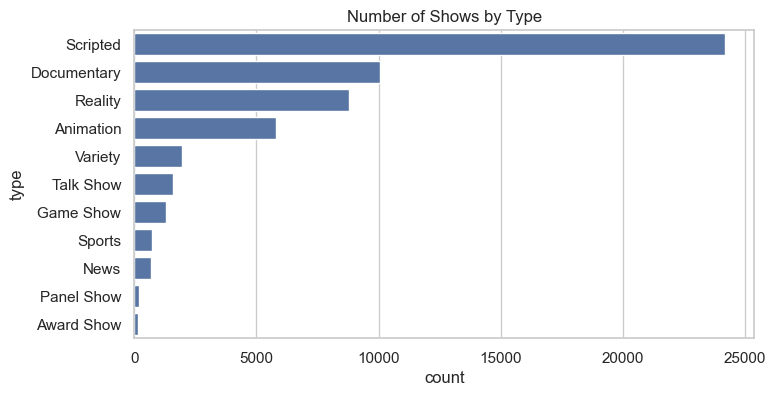

In [452]:
# View count by show-type
type_data = data.groupby('type').count().orderBy(desc('count')) # Added order for consistency
print("Counts by Show Type:")
display(type_data)

# Convert to Pandas for plotting (fine for small aggregated data)
types_pandas = type_data.toPandas()

# Plotting
sns.set_theme(style="whitegrid") # Use set_theme for modern seaborn
plt.figure(figsize=(8, 4)) # Optional: Adjust figure size
sns.barplot(data=types_pandas, x='count', y='type')
plt.title('Number of Shows by Type') # Add a title
plt.show() # Explicitly show plot

### Runtime Analysis & Visualization:

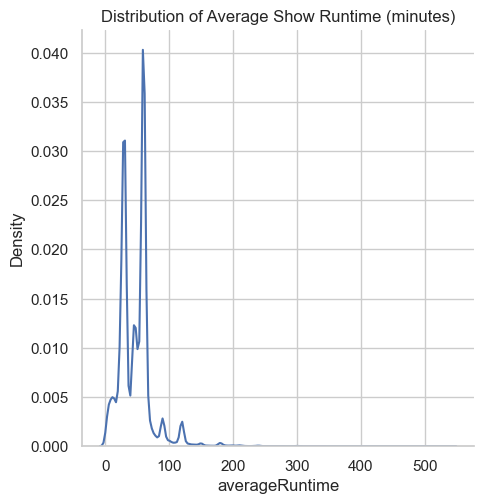

In [454]:
# Analyze Average Runtime distribution
# Grouping by runtime and counting is valid but doesn't directly give the distribution plot desired
# x_data = data.groupby('averageRuntime').count()
# display(x_data.limit(5))

# For plotting the distribution of runtimes, work with the column directly
# Filter out potential nulls or invalid values if necessary
runtime_data_pd = data.select("averageRuntime").filter(col("averageRuntime").isNotNull()).toPandas()

# Plot the distribution (KDE)
sns.displot(data=runtime_data_pd, x='averageRuntime', kind="kde")
plt.title('Distribution of Average Show Runtime (minutes)')
plt.show()

# -- If the dataset is HUGE, sample before toPandas --
# sample_fraction = 0.1 # Adjust as needed
# runtime_data_pd_sampled = data.select("averageRuntime") \
#                                .filter(col("averageRuntime").isNotNull()) \
#                                .sample(withReplacement=False, fraction=sample_fraction) \
#                                .toPandas()
# sns.displot(data=runtime_data_pd_sampled, x='averageRuntime', kind="kde")
# plt.title(f'Distribution of Average Show Runtime (Sampled {int(sample_fraction*100)}%)')
# plt.show()

## Distribution of average ratings

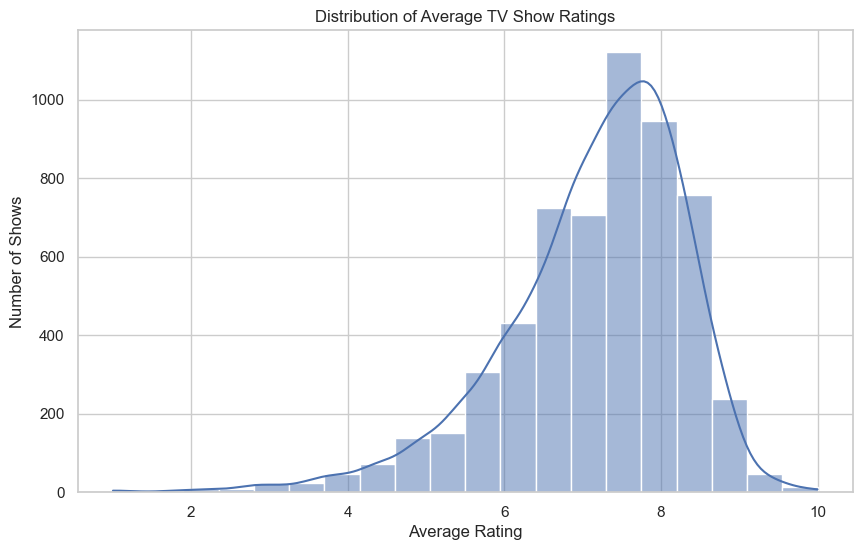

Analyzed 5765 shows with ratings.


In [456]:
# Select the nested 'rating.average' field, alias it, drop nulls, and convert to Pandas
ratings_pd = data.select(col("rating.average").alias("average_rating")) \
                 .filter(col("average_rating").isNotNull()) \
                 .toPandas()

# Plot the distribution
plt.figure(figsize=(10, 6))
sns.histplot(ratings_pd['average_rating'], kde=True, bins=20)
plt.title('Distribution of Average TV Show Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Shows')
plt.show()

print(f"Analyzed {len(ratings_pd)} shows with ratings.")

## Top N genres

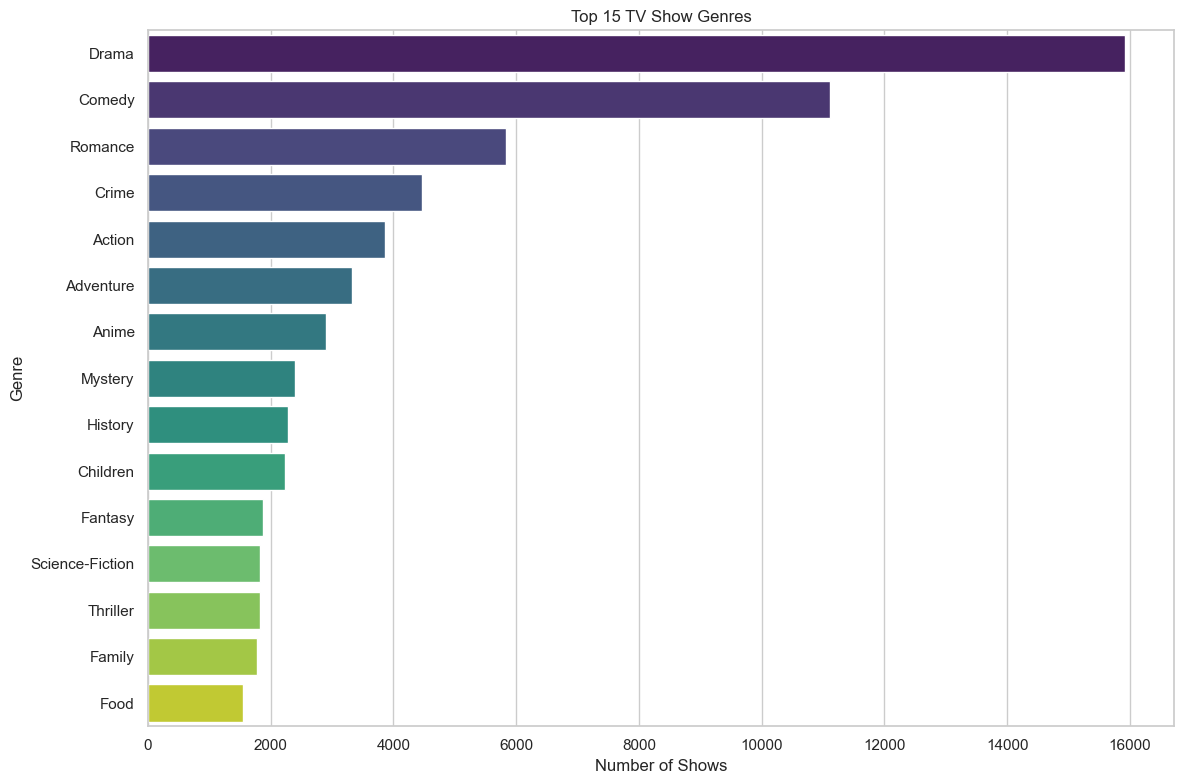

In [458]:
# Explode the 'genres' array, count each genre, order, and take top N
top_n_genres = 15
genres_counts_pd = data.select(explode("genres").alias("genre")) \
                       .filter(col("genre").isNotNull() & (col("genre") != "")) \
                       .groupBy("genre") \
                       .agg(count("*").alias("show_count")) \
                       .orderBy(desc("show_count")) \
                       .limit(top_n_genres) \
                       .toPandas()

# Plot the counts
plt.figure(figsize=(12, 8))
sns.barplot(data=genres_counts_pd, x="show_count", y="genre", hue="genre", palette="viridis", legend=False)
plt.title(f'Top {top_n_genres} TV Show Genres')
plt.xlabel('Number of Shows')
plt.ylabel('Genre')
plt.tight_layout()
plt.show()

## Number of shows premiered per year

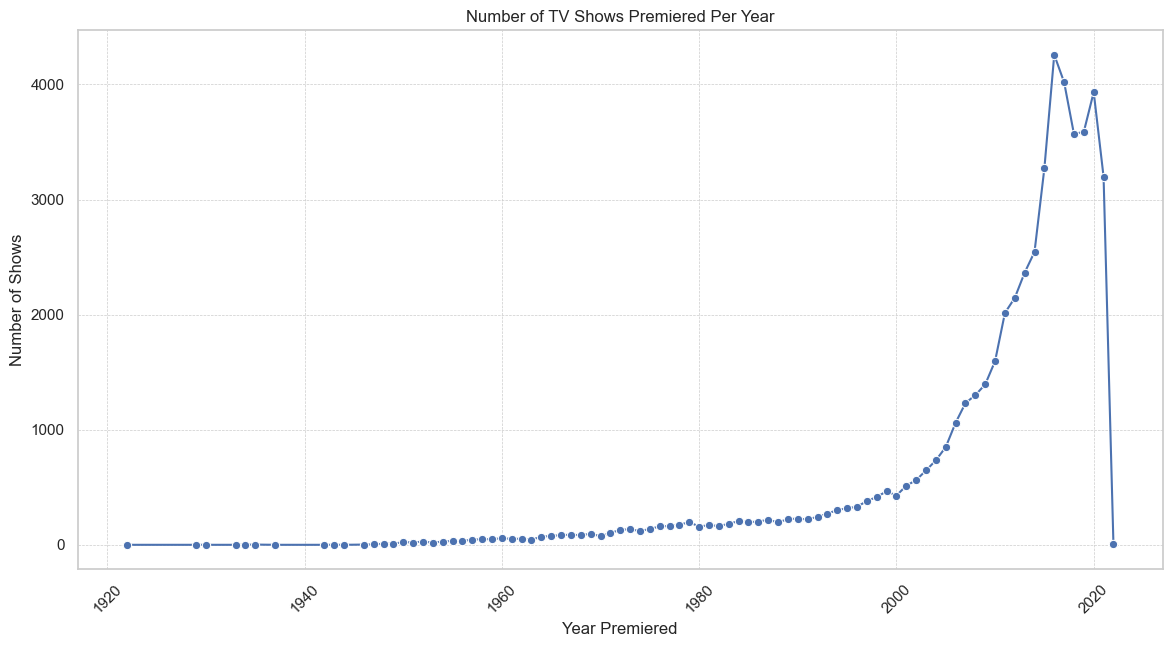

In [459]:
# Extract year from 'premiered', filter invalid/null years, count shows per year, order
shows_per_year_pd = data.withColumn("premier_year", year(col("premiered"))) \
                        .filter(col("premier_year").isNotNull() & (col("premier_year") > 1900)) \
                        .groupBy("premier_year") \
                        .agg(count("*").alias("show_count")) \
                        .orderBy("premier_year") \
                        .toPandas()

# Plot the trend
plt.figure(figsize=(14, 7))
sns.lineplot(data=shows_per_year_pd, x="premier_year", y="show_count", marker='o') # Added marker
plt.title('Number of TV Shows Premiered Per Year')
plt.xlabel('Year Premiered')
plt.ylabel('Number of Shows')
plt.xticks(rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5) # Enhanced grid
plt.show()

## Average rating by show status

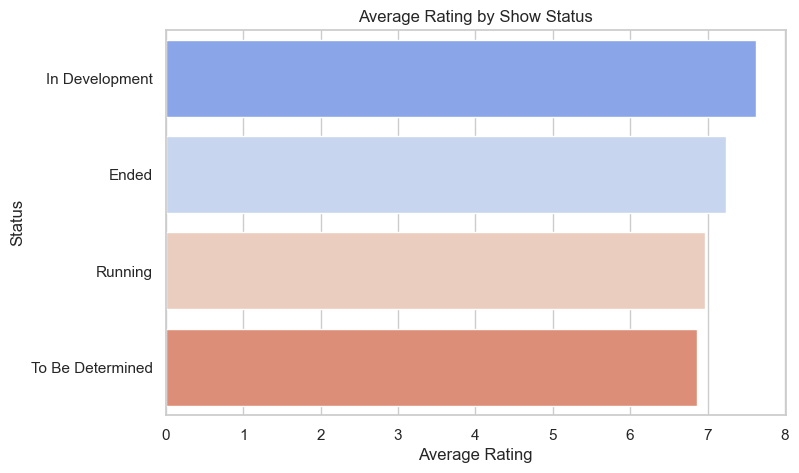


Average Rating per Status:
             status  mean_rating  show_count
0    In Development     7.628571          14
1             Ended     7.240483        4014
2           Running     6.966538        1294
3  To Be Determined     6.866366         443


In [460]:
# Group by 'status', calculate average of 'rating.average', filter nulls
status_ratings_pd = data.filter(col("status").isNotNull() & col("rating.average").isNotNull()) \
                        .groupBy("status") \
                        .agg(avg(col("rating.average")).alias("mean_rating"),
                             count("*").alias("show_count")) \
                        .orderBy(desc("mean_rating")) \
                        .toPandas()

# Optional: Filter out statuses with very few shows
# status_ratings_pd = status_ratings_pd[status_ratings_pd['show_count'] > 10]

# Bar Plot (Shows Average)
plt.figure(figsize=(8, 5))
sns.barplot(data=status_ratings_pd, x="mean_rating", y="status", hue="status", palette="coolwarm", legend=False)
plt.title('Average Rating by Show Status')
plt.xlabel('Average Rating')
plt.ylabel('Status')
plt.show()

# Optional Box Plot (Shows Distribution)
# status_ratings_dist_pd = data.select("status", col("rating.average").alias("average_rating")) \
#                              .filter(col("status").isNotNull() & col("average_rating").isNotNull()) \
#                              .limit(5000) # Limit if data is huge before toPandas for boxplot
#                              .toPandas()
# plt.figure(figsize=(10, 6))
# sns.boxplot(data=status_ratings_dist_pd, x="average_rating", y="status", palette="coolwarm")
# plt.title('Distribution of Ratings by Show Status')
# plt.xlabel('Average Rating')
# plt.ylabel('Status')
# plt.show()

print("\nAverage Rating per Status:")
print(status_ratings_pd)

## Relationship between runtime and average rating

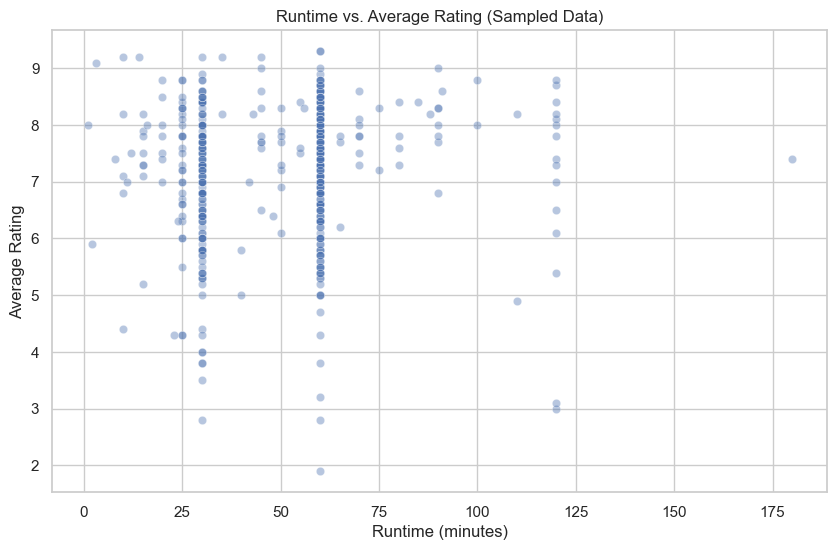

Plotted 526 sampled shows.

Correlation between runtime and average rating (in sample): 0.069


In [461]:
# Select 'runtime' and 'rating.average', ensure numeric, filter nulls
# Sample if dataset is large! Adjust fraction as needed.
runtime_rating_pd = data.select(col("runtime").cast("integer"),
                                col("rating.average").alias("average_rating")) \
                        .filter(col("runtime").isNotNull() & \
                                col("average_rating").isNotNull() & \
                                (col("runtime") > 0)) \
                        .sample(fraction=0.1, withReplacement=False, seed=42) \
                        .toPandas()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=runtime_rating_pd, x="runtime", y="average_rating", alpha=0.4)
plt.title('Runtime vs. Average Rating (Sampled Data)')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Average Rating')
# Optional: Limit x-axis if there are extreme outliers in runtime
# plt.xlim(0, 200)
plt.show()

print(f"Plotted {len(runtime_rating_pd)} sampled shows.")

# Optional: Calculate correlation
if not runtime_rating_pd.empty:
    correlation = runtime_rating_pd['runtime'].corr(runtime_rating_pd['average_rating'])
    print(f"\nCorrelation between runtime and average rating (in sample): {correlation:.3f}")
else:
    print("\nNot enough data in sample to calculate correlation.")

## Top N networks

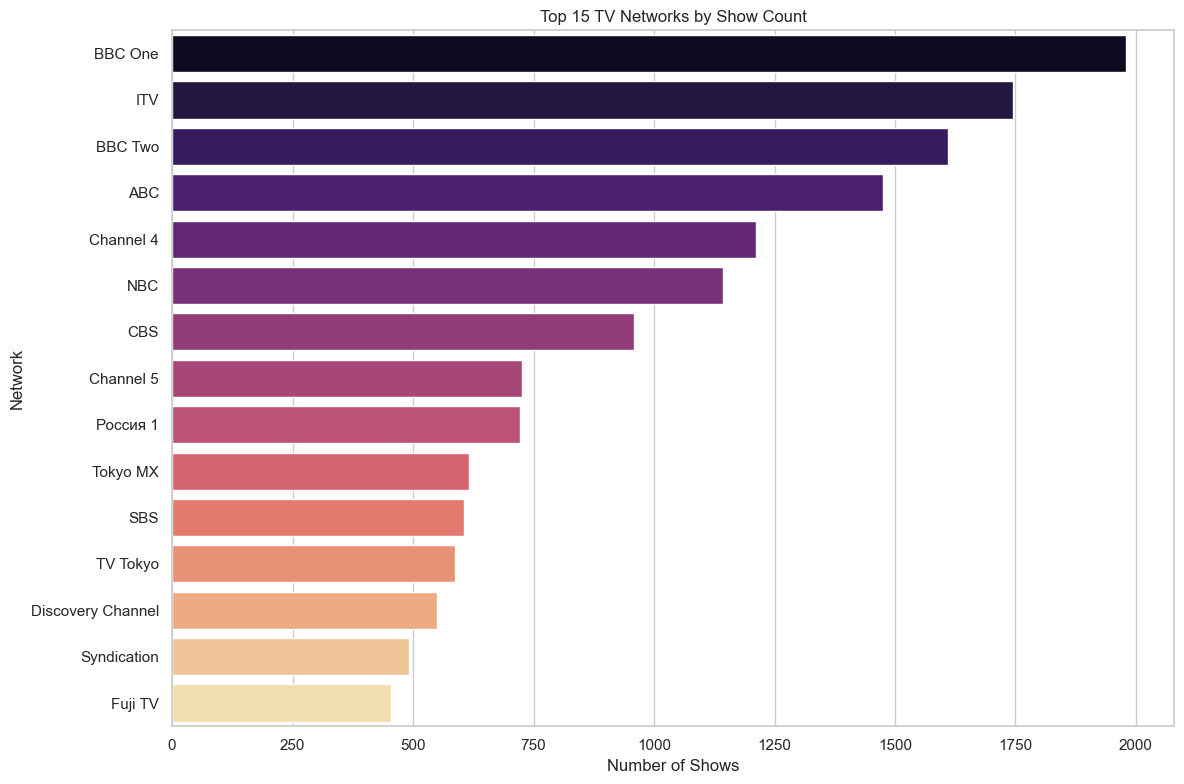

In [462]:
# Select the nested 'network.name', filter nulls, count shows per network, order
top_n_networks = 15
network_counts_pd = data.select(col("network.name").alias("network_name")) \
                        .filter(col("network_name").isNotNull() & (col("network_name") != "")) \
                        .groupBy("network_name") \
                        .agg(count("*").alias("show_count")) \
                        .orderBy(desc("show_count")) \
                        .limit(top_n_networks) \
                        .toPandas()

# Plot the counts
plt.figure(figsize=(12, 8))
sns.barplot(data=network_counts_pd, x="show_count", y="network_name",hue="network_name", palette="magma", legend=False)
plt.title(f'Top {top_n_networks} TV Networks by Show Count')
plt.xlabel('Number of Shows')
plt.ylabel('Network')
plt.tight_layout()
plt.show()

## Distribution of show types

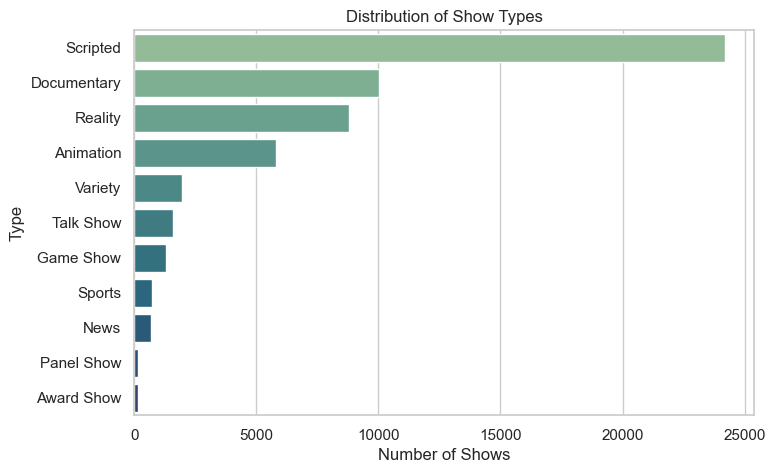


Show Counts per Type:
           type  show_count
0      Scripted       24193
1   Documentary       10042
2       Reality        8778
3     Animation        5810
4       Variety        1950
5     Talk Show        1582
6     Game Show        1298
7        Sports         702
8          News         692
9    Panel Show         168
10   Award Show         147


In [463]:
# Group by 'type', count shows per type
type_counts_pd = data.filter(col("type").isNotNull() & (col("type") != "")) \
                     .groupBy("type") \
                     .agg(count("*").alias("show_count")) \
                     .orderBy(desc("show_count")) \
                     .toPandas()

# Plot using a bar chart (good for comparing counts)
plt.figure(figsize=(8, 5))
sns.barplot(data=type_counts_pd, x="show_count", y="type", hue="type", palette="crest", legend=False)
plt.title('Distribution of Show Types')
plt.xlabel('Number of Shows')
plt.ylabel('Type')
plt.show()

# Optional: Pie chart (good for showing proportions if categories are few)
# plt.figure(figsize=(8, 8))
# plt.pie(type_counts_pd['show_count'], labels=type_counts_pd['type'], autopct='%1.1f%%', startangle=140)
# plt.title('Proportion of Show Types')
# plt.show()

print("\nShow Counts per Type:")
print(type_counts_pd)

## Violin Plot: Average Rating Distribution by Show Status

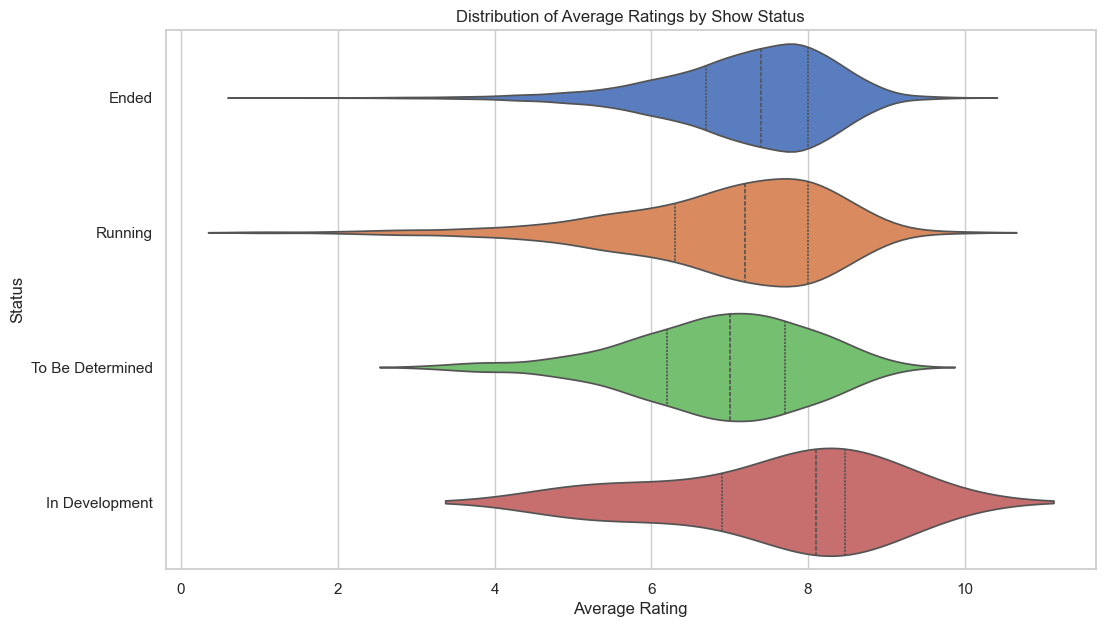

Plotted distributions for 5765 shows with status and rating.


In [464]:
# Select status and rating.average, filter nulls
# No aggregation needed here, we want the distribution of individual ratings
status_ratings_dist_pd = data.select("status", col("rating.average").alias("average_rating")) \
                             .filter(col("status").isNotNull() & \
                                     col("average_rating").isNotNull() & \
                                     (col("status") != "")) \
                             .toPandas() # Be mindful of data size here! Add .limit(N) if needed.

# Plot the violin plot
plt.figure(figsize=(12, 7))
sns.violinplot(data=status_ratings_dist_pd, y="status", hue="status", x="average_rating", palette="muted", inner="quartile", legend=False)
# 'inner="quartile"' adds lines for quartiles inside the violins
# Other options for 'inner': 'box', 'point', 'stick', None

plt.title('Distribution of Average Ratings by Show Status')
plt.xlabel('Average Rating')
plt.ylabel('Status')
plt.show()

print(f"Plotted distributions for {len(status_ratings_dist_pd)} shows with status and rating.")

## Violin Plot: Runtime Distribution by Show Type

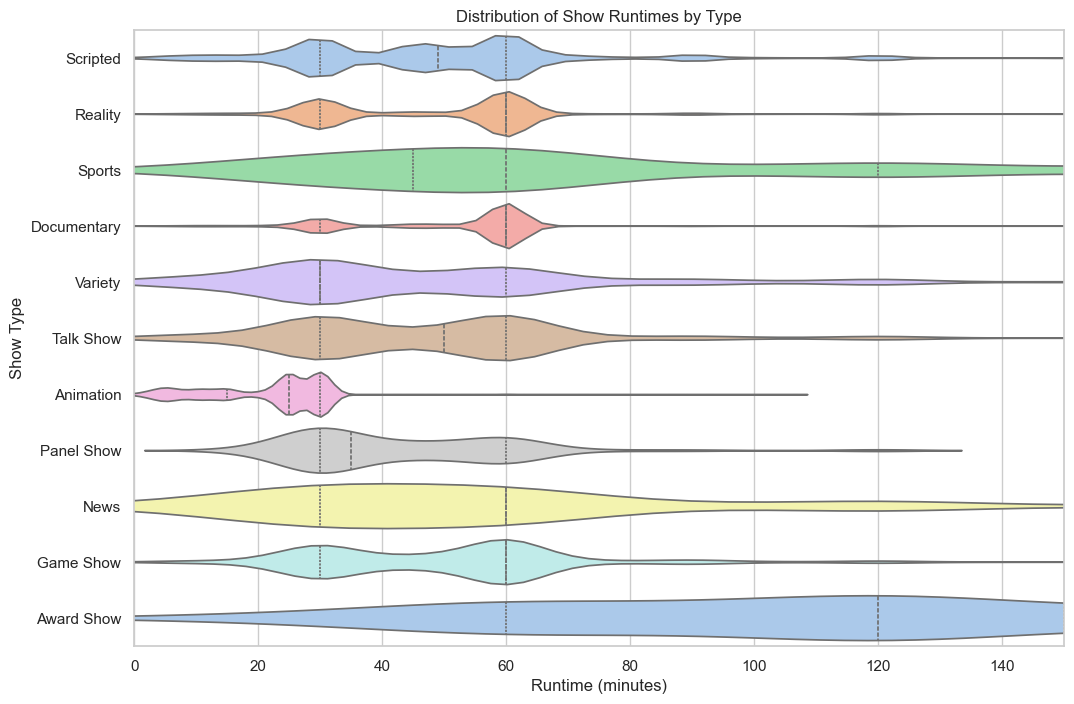

Plotted distributions for 50588 shows with type and valid runtime.


In [465]:
# Cell 9: Violin Plot: Runtime Distribution by Show Type (Corrected)

# Select type and runtime, filter nulls and non-positive runtimes
type_runtime_dist_pd = data.select("type", col("runtime").cast("integer").alias("runtime_mins")) \
                           .filter(col("type").isNotNull() & \
                                   col("runtime_mins").isNotNull() & \
                                   (col("type") != "") & \
                                   (col("runtime_mins") > 0)) \
                           .toPandas() # Again, be mindful of data size. Add .limit(N) if needed.

# Plot the violin plot - UPDATED LINE
plt.figure(figsize=(12, 8))
sns.violinplot(
    data=type_runtime_dist_pd,
    y="type",
    x="runtime_mins",
    hue="type",             # Assign y variable to hue as recommended
    palette="pastel",
    inner="quartile",
    density_norm='width',   # Use the new parameter name for scaling
    legend=False            # Disable the legend created by hue
)

plt.title('Distribution of Show Runtimes by Type')
plt.xlabel('Runtime (minutes)')
plt.ylabel('Show Type')

# Optional: Limit x-axis if extreme outliers skew the plot
plt.xlim(0, 150) # Example: Set a reasonable upper limit

plt.show()

print(f"Plotted distributions for {len(type_runtime_dist_pd)} shows with type and valid runtime.")

# Optional: Show counts per type
# print("\nCounts per type for runtime analysis:")
# print(type_runtime_dist_pd['type'].value_counts())

## Summary, Conclusions, and Next Steps

This notebook conducted an exploratory data analysis (EDA) on a dataset of TV shows (`tv_shows.json`), leveraging PySpark for scalable processing and Matplotlib/Seaborn for visualization.

### **Key Findings**

1. **Ratings Distribution:**  
   Most rated shows fall within the _e.g., 6.5 to 8.5_ average rating range. A non-trivial number of shows lack ratings, which could be an area for further investigation (why are they missing?).

2. **Dominant Genres:**  
   _E.g., Scripted Drama and Comedy_ represent a large portion of the dataset, reflecting common TV programming. The long tail of niche genres was also evident.

3. **Growth Over Time:**  
   A significant increase in the number of shows premiering per year was observed, particularly from _e.g., the early 2000s onwards_, indicating industry growth.

4. **Categorical Comparisons:**
   - **Status:**  
     Violin plots showed that while median ratings might be similar across statuses like _'Ended'_ and _'Running'_, the **distribution** of ratings differs, with _e.g., Ended shows exhibiting greater variance_.
   - **Type:**  
     Show types like _e.g., 'Animation'_ and _'Reality'_ generally have distinct runtime profiles compared to _e.g., 'Scripted'_ shows.

5. **Network Proliferation:**  
   Both established networks (_e.g., CBS, Showtime_) and newer platforms (_e.g., Netflix, Amazon Prime Video_) contribute significantly to the show count.

6. **Runtime vs. Rating:**  
   No strong linear correlation was apparent between show runtime and average rating in the analyzed sample, suggesting other factors are more influential on ratings.

---

### **Limitations**

- Analysis is constrained by the schema of the input JSON and the completeness of the data.
- Null values, particularly in critical fields like `rating.average`, were filtered, potentially impacting the generalizability of findings related to ratings.
- Driver memory constraints necessitated aggregation or sampling before certain visualizations using `.toPandas()`.

---

### **Potential Next Steps**

1. **Text Analysis:**  
   Apply Natural Language Processing (NLP) techniques to the `summary` field to extract topics, sentiment, or keywords and correlate them with ratings or genres.

2. **Time-Series Deeper Dive:**  
   Analyze trends _within_ specific genres or networks over time. Are certain genres growing faster?

3. **Network/Web Channel Comparison:**  
   Perform a more detailed comparison between shows on traditional networks versus web channels/streaming services (e.g., average ratings, genres produced, runtimes).

4. **External Data Integration:**  
   Enrich the dataset with external information (e.g., detailed cast/crew information, awards, viewership numbers if available) for more complex modeling.

5. **Predictive Modeling:**  
   Attempt to build a model to predict show ratings based on available features (genre, runtime, network, type, etc.), carefully handling the missing data challenge.

---

This EDA provides valuable insights and highlights promising avenues for more in-depth future analysis of this TV show dataset.


In [466]:
print("Stopping Spark session...")
spark.stop()
print("Spark session stopped.")

Stopping Spark session...
Spark session stopped.
